# Setup and Getting Data

In [1]:
#!pip install albumentations

In [2]:
import os #join file paths
import time #time to move around bw pictures
import uuid #uniform unique identifier
import cv2 #capture, collect and work on images

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
# """
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()
# """

In [5]:
# !labelme

# Review Dataset and Build Image Loading Function

In [11]:
import tensorflow as tf
import json #labels are in json format
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
#images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle = False)

In [14]:
#images.as_numpy_iterator().next()

In [15]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
#images = images.map(load_image)

In [17]:
#images.as_numpy_iterator().next()

In [18]:
#type(images)

In [19]:
#image_generator = images.batch(4).as_numpy_iterator()

In [20]:
#plot_images = image_generator.next()

In [21]:
# """
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, image in enumerate(plot_images):
#     ax[idx].imshow(image) 
# plt.show()
# """

# Partition Unaugmented Data

In [22]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation on Images and Labels using Albumentations

In [24]:
import albumentations as alb

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=950, height=950), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [26]:
img = cv2.imread(os.path.join('data','train', 'images','5e678328-0d2d-11ee-a091-46c3123a06d9.jpg'))

In [27]:
img.shape

(1080, 1920, 3)

In [28]:
with open(os.path.join('data', 'train', 'labels', '5e678328-0d2d-11ee-a091-46c3123a06d9.json'), 'r') as f:
    label = json.load(f)

In [29]:
label['shapes'][0]

{'label': 'face',
 'points': [[375.3636363636364, 504.81818181818187],
  [704.9090909090909, 845.7272727272727]],
 'group_id': None,
 'shape_type': 'rectangle',
 'flags': {}}

In [30]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [31]:
coords

[375.3636363636364, 504.81818181818187, 704.9090909090909, 845.7272727272727]

In [32]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [33]:
coords

[0.19550189393939393,
 0.46742424242424246,
 0.3671401515151515,
 0.7830808080808082]

In [34]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [35]:
augmented['image'].shape

(950, 950, 3)

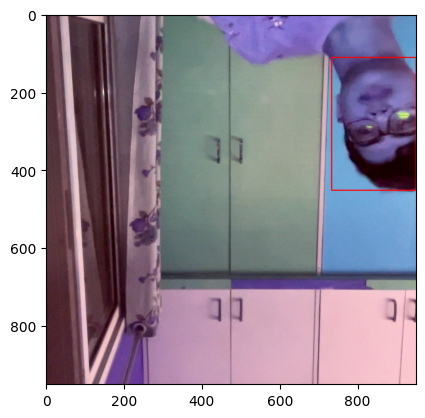

In [36]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [950,950]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [950,950]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.2617897727272727, 0.8504208754208754, 0.0, 0.3925925925925926, 'face'].
x_max is less than or equal to x_min for bbox [0.5565340909090909, 0.7893939393939393, 0.31150568181818183, 0.1054713804713805, 'face'].
x_max is less than or equal to x_min for bbox [0.36950757575757576, 0.8146464646464646, 0.09607007575757577, 0.27382154882154885, 'face'].
image must be numpy array type
image must be numpy array type


In [38]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [39]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

array([[[0.5068559 , 0.47433278, 0.53545755],
        [0.5088031 , 0.47350898, 0.54311687],
        [0.51385486, 0.47474128, 0.55052423],
        ...,
        [0.66254765, 0.6404888 , 0.7014365 ],
        [0.64918303, 0.63349676, 0.69456697],
        [0.6531046 , 0.6374183 , 0.69526833]],

       [[0.50394195, 0.46080476, 0.51570666],
        [0.5113358 , 0.46819854, 0.53094363],
        [0.50153184, 0.45839462, 0.51819855],
        ...,
        [0.66290855, 0.6467321 , 0.68643796],
        [0.6681985 , 0.6474265 , 0.6954044 ],
        [0.6627451 , 0.63662165, 0.6967117 ]],

       [[0.50085104, 0.45150465, 0.509838  ],
        [0.49846813, 0.4491217 , 0.5022263 ],
        [0.4964052 , 0.44150326, 0.5026143 ],
        ...,
        [0.66747695, 0.6377382 , 0.7016272 ],
        [0.654902  , 0.6392157 , 0.69803923],
        [0.6612406 , 0.63656735, 0.69375694]],

       ...,

       [[0.38039216, 0.32336602, 0.47091505],
        [0.38196498, 0.32020026, 0.44879487],
        [0.45717612, 0

# Prepare Labels

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.6274, 0.2837, 1.    , 0.8745], dtype=float16))

# Combine Label and Image Samples

In [47]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2220, 2220, 540, 540, 540, 540)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [52]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.292 , 0.1334, 0.7466, 0.691 ],
        [0.3262, 0.2705, 0.7256, 0.7944],
        [0.802 , 0.2   , 1.    , 0.4512],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3538, 0.2856, 0.6885, 0.7905],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3035, 0.2332, 0.77  , 0.824 ]], dtype=float16))

In [53]:
data_samples = train.as_numpy_iterator()

In [54]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 3 is out of bounds for axis 0 with size 3

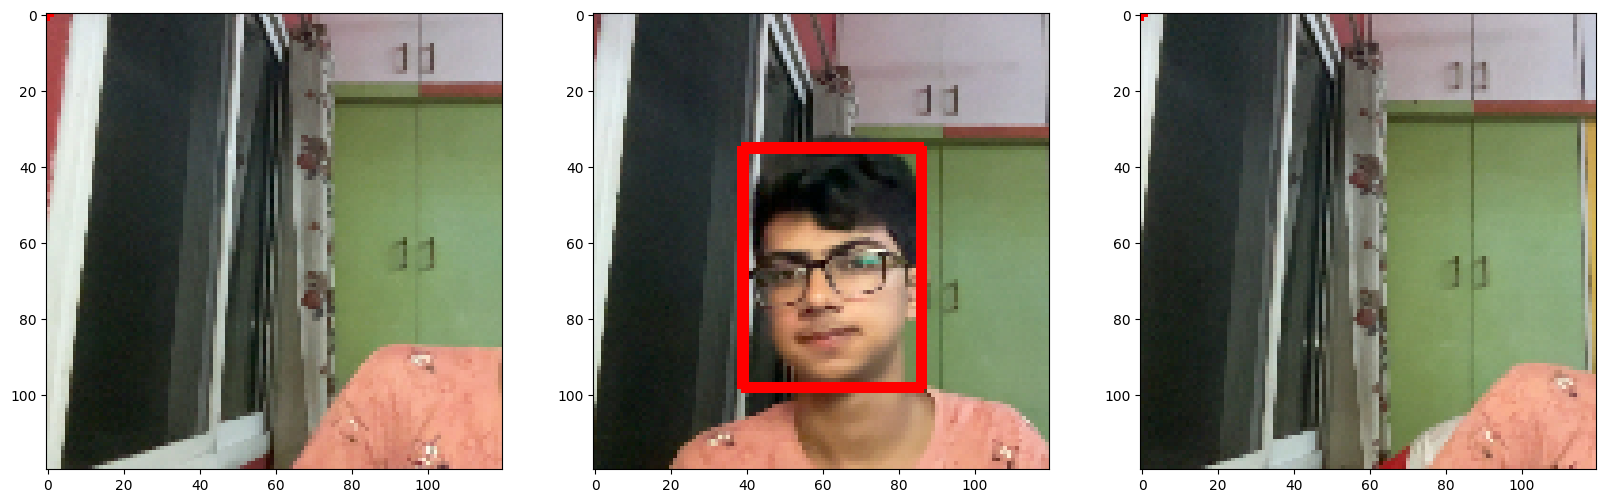

In [55]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig, ax = plt.subplots(ncols=3, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [57]:
vgg = VGG16(include_top=False)

In [58]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [59]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [60]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2037  , 0.1486  , 0.6704  , 0.7397  ],
        [0.2004  , 0.5845  , 0.4133  , 0.869   ],
        [0.      , 0.001148, 0.502   , 0.831   ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.04355 , 0.4219  , 0.3904  , 0.781   ],
        [0.08405 , 0.2065  , 0.4836  , 0.7305  ],
        [0.      , 0.1958  , 0.09796 , 0.722   ],
        [0.468   , 0.0842  , 0.6665  , 0.3354  ]], dtype=float16))

In [61]:
facetracker = build_model()

In [62]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [63]:
X, y = train.as_numpy_iterator().next()

In [64]:
X.shape

(8, 120, 120, 3)

In [65]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 315ms/step


In [66]:
classes, coords

(array([[0.45066494],
        [0.46788672],
        [0.5726789 ],
        [0.43424147],
        [0.501572  ],
        [0.46851712],
        [0.4528328 ],
        [0.534227  ]], dtype=float32),
 array([[0.3411712 , 0.44681248, 0.5821457 , 0.4197649 ],
        [0.20683157, 0.38691804, 0.6560104 , 0.48748457],
        [0.24142583, 0.51799643, 0.5745654 , 0.5097152 ],
        [0.25590476, 0.36835074, 0.6294849 , 0.38819468],
        [0.22339259, 0.40028104, 0.5979757 , 0.43448523],
        [0.32627267, 0.43840718, 0.6556563 , 0.42081973],
        [0.27594188, 0.50154805, 0.64404494, 0.4025032 ],
        [0.27894035, 0.41633624, 0.6205525 , 0.44745597]], dtype=float32))

# Define Losses and Optimizers

In [67]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [68]:
import tensorflow as tf

# Use the legacy optimizer for M1/M2 Macs
if tf.config.list_physical_devices('GPU') and 'M1' in tf.config.list_physical_devices('GPU')[0].name:
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
else:
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Adjust the optimizer configuration based on the specific requirements
# of your model and training process


In [69]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [71]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.9908752>

In [72]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.68611073>

In [73]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.9908752>

# Train Neural Network

In [74]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [75]:
model = FaceTracker(facetracker)

In [76]:
model.compile(opt, classloss, regressloss)

In [77]:
logdir='logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [79]:
hist = model.fit(train, epochs=6, validation_data=val, callbacks=[tensorboard_callback]) 

Epoch 1/6
278/278 [==============================] - 274s 973ms/step - total_loss: 0.5060 - class_loss: 0.1345 - regress_loss: 0.4387 - val_total_loss: 0.1040 - val_class_loss: 0.0410 - val_regress_loss: 0.0835
Epoch 2/6
278/278 [==============================] - 375s 1s/step - total_loss: 0.3049 - class_loss: 0.0896 - regress_loss: 0.2601 - val_total_loss: 0.1066 - val_class_loss: 0.0929 - val_regress_loss: 0.0602
Epoch 3/6
278/278 [==============================] - 404s 1s/step - total_loss: 0.2075 - class_loss: 0.0682 - regress_loss: 0.1734 - val_total_loss: 0.1089 - val_class_loss: 0.0979 - val_regress_loss: 0.0600
Epoch 4/6
278/278 [==============================] - 396s 1s/step - total_loss: 0.1681 - class_loss: 0.0554 - regress_loss: 0.1405 - val_total_loss: 0.0268 - val_class_loss: 0.0065 - val_regress_loss: 0.0235
Epoch 5/6
278/278 [==============================] - 394s 1s/step - total_loss: 0.1109 - class_loss: 0.0351 - regress_loss: 0.0934 - val_total_loss: 0.0067 - val_cla

In [80]:
hist.history

{'total_loss': [0.04594692215323448,
  0.05081256106495857,
  0.1233004704117775,
  0.030187958851456642,
  0.016012001782655716,
  0.008655800484120846],
 'class_loss': [0.0016150405863299966,
  0.004970730748027563,
  0.11653245985507965,
  0.014774058014154434,
  2.4930139261414297e-05,
  0.0060903518460690975],
 'regress_loss': [0.04513940215110779,
  0.04832719638943672,
  0.06503424048423767,
  0.022800929844379425,
  0.015999536961317062,
  0.005610624328255653],
 'val_total_loss': [0.10400252044200897,
  0.1065913587808609,
  0.1088942438364029,
  0.026751425117254257,
  0.00674743065610528,
  0.009146989323198795],
 'val_class_loss': [0.04100754112005234,
  0.09286095201969147,
  0.09788374602794647,
  0.006514253094792366,
  8.858061482897028e-05,
  0.003775383811444044],
 'val_regress_loss': [0.0834987461566925,
  0.06016087904572487,
  0.05995236709713936,
  0.02349429950118065,
  0.006703140214085579,
  0.007259297650307417]}

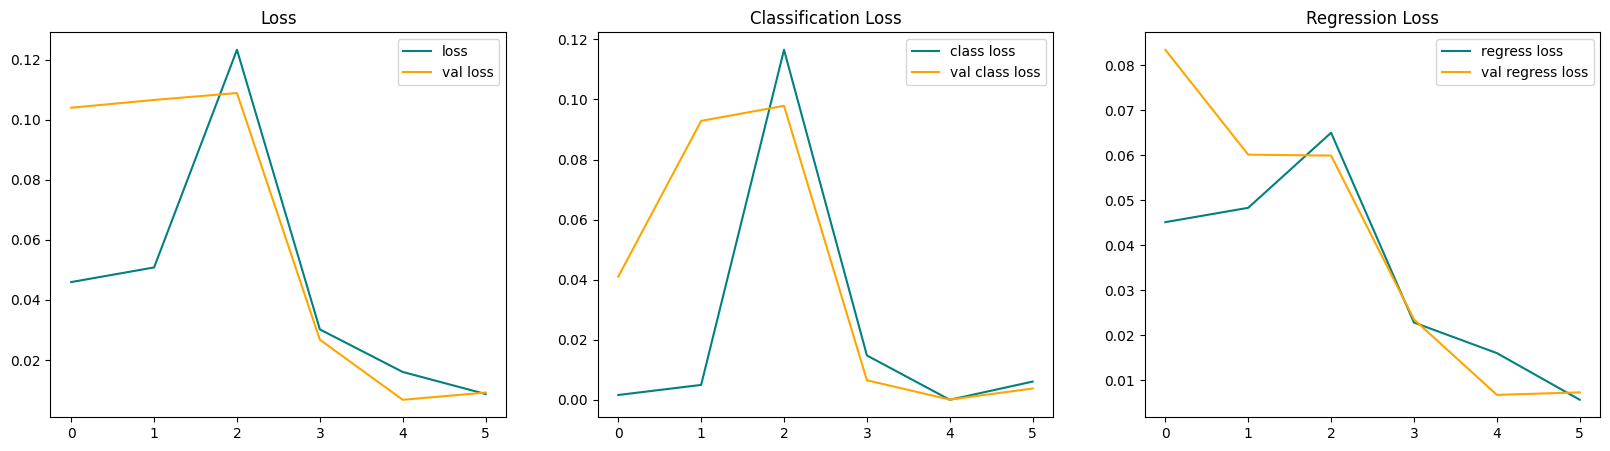

In [81]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [82]:
test_data = test.as_numpy_iterator()

In [83]:
test_sample = test_data.next()

In [84]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 235ms/step


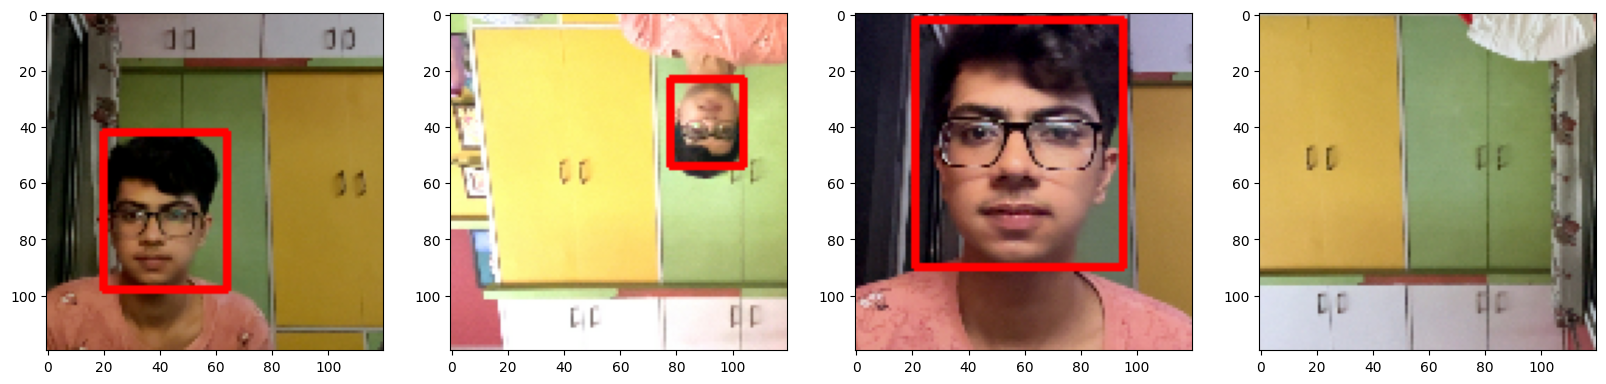

In [85]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [86]:
from tensorflow.keras.models import load_model

In [87]:
facetracker.save('facetracker.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [88]:
facetracker = load_model('facetracker.h5')

In [90]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:1100, 50:1100,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [1050,1050]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [1050,1050]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [1050,1050]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [1050,1050]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [1050,1050]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 38ms/step


: 